In [5]:
import pandas as pd


In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive')
os.chdir('NLP-Project/')

Mounted at /content/drive


In [7]:

# Load the cleaned dataset
data = pd.read_csv('priority_labeled_emails.csv')
data.head(10)

,From,Subject,Body,priority
0,Kohls@s.kohls.com,Save the date! Get up to 50% off beauty faves ...,plus stressfree holiday flawless gift set ͏ ͏ ...,High
1,noreply@content.goibibo.com,Bus cancelled = 2x refund!,goibibo here’s claim offer follow u download g...,Low
2,Kohls@s.kohls.com,Plot twist: Get Black Friday Deals TODAY 🤯 Plu...,save 85 clearance mark calendar sephora cyber ...,High
3,info@members.netflix.com,🔔 Reminder: A Man on the Inside is now on Netflix,here reminder start watching rish man inside 2...,Medium
4,googlecloud@google.com,"Launch and learn with interactive, prebuilt so...",google cloud­ deploy prebuilt google cloud sol...,Low
5,mailers@marketing.goindigo.in,We're celebrating Ethics Week with you,share thought feedback honour commitment view ...,Medium
6,CaratLane@mailer.caratlane.com,📈 Trending this week: NEW RINGS,0,Medium
7,noreply@miraeassetmf.co.in,🚀 Launching: Mirae Asset Long Duration Fund,click unsubscribe newsletter,Medium
8,email@market.temuemail.com,"Your Purchase, Our Thanks!",temu properly view full message content please...,High
9,noreply@medium.com,A Founder Who Just Raised a $3 Million Seed Ro...,story rishitha pusapati pusapatirishitha98 ·be...,High


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [9]:
# Combine 'Subject' and 'Body' into a single feature
data['text'] = data['Subject'].fillna('') + ' ' + data['Body'].fillna('')

# Encode the target variable
data['priority'] = data['priority'].map({'Low': 0, 'Medium': 1, 'High': 2})



In [10]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['priority'], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Training Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)



In [11]:
# Evaluate the model
report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])
print(report)



              precision    recall  f1-score   support

         Low       0.93      0.92      0.92      1555
      Medium       0.90      0.93      0.91      1114
        High       0.93      0.88      0.90       625

    accuracy                           0.92      3294
   macro avg       0.92      0.91      0.91      3294
weighted avg       0.92      0.92      0.92      3294



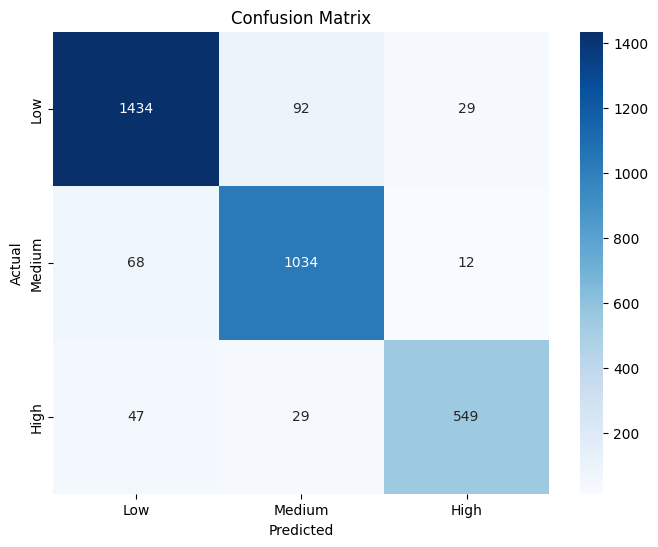

In [12]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



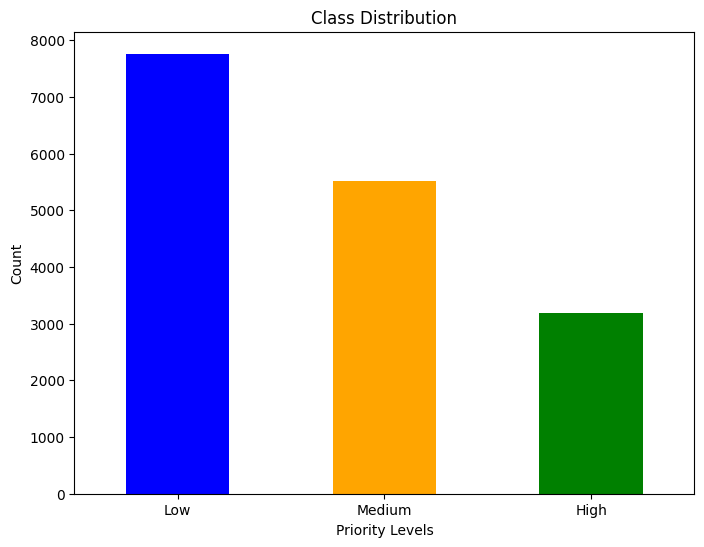

In [13]:
# Plot class distribution
plt.figure(figsize=(8, 6))
data['priority'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Class Distribution')
plt.xlabel('Priority Levels')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'], rotation=0)
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train_tfidf, y_train)
print("Best Parameters:", grid.best_params_)


Best Parameters: {'C': 10, 'penalty': 'l2'}


In [15]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1555
           1       0.94      0.96      0.95      1114
           2       0.97      0.92      0.94       625

    accuracy                           0.95      3294
   macro avg       0.95      0.94      0.95      3294
weighted avg       0.95      0.95      0.95      3294



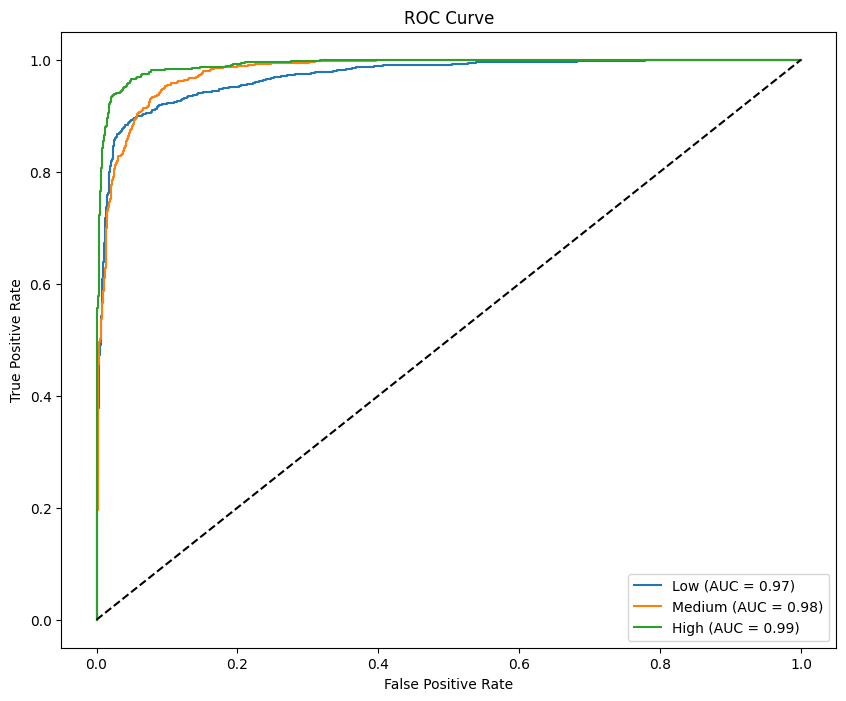

In [16]:
# ROC Curve
plt.figure(figsize=(10, 8))
for i, label in enumerate(['Low', 'Medium', 'High']):
    y_test_binary = (y_test == i).astype(int)
    y_score = model.decision_function(X_test_tfidf)[:, i] if hasattr(model, "decision_function") else model.predict_proba(X_test_tfidf)[:, i]
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['priority'])

# Test with new examples
test_emails = [
    # Promotional Email
    {"Subject": "Flash Sale Alert!",
     "Body": "Hurry! Get 70% off on electronics. Limited time only."},
    # Business Email
    {"Subject": "Quarterly Business Review Scheduled",
     "Body": "Join us for the QBR scheduled next Monday at 10 AM."},
    # Casual Email
    {"Subject": "Lunch Plans?",
     "Body": "Hey, do you want to grab lunch tomorrow? Let me know!"},
    # Personal Email
    {"Subject": "Happy Birthday!",
     "Body": "Wishing you a fantastic year ahead! Let’s celebrate soon."},
    # Spam-like Email
    {"Subject": "You’ve Won a $1,000 Gift Card!",
     "Body": "Click here to claim your prize. Offer valid for 24 hours."},
    # Work Reminder Email
    {"Subject": "Action Required: Complete Your Timesheet",
     "Body": "Please submit your timesheet by the end of the day."},
    # Informative Email
    {"Subject": "Weekly Newsletter: Top News Highlights",
     "Body": "Check out this week’s top stories and trending topics."},
    # Urgent Work Email
    {"Subject": "URGENT: Client Presentation Updates Needed",
     "Body": "Please send the revised slides for the presentation ASAP."},
    # Social Media Notification
    {"Subject": "Someone Liked Your Post!",
     "Body": "Your post is gaining traction. Check out the latest stats."},
    # Subscription Renewal Email
    {"Subject": "Your Subscription is Expiring Soon",
     "Body": "Renew your subscription today to continue enjoying our service."}
]

# Combine subject and body for test examples
test_texts = [email['Subject'] + " " + email['Body'] for email in test_emails]

# Transform the test examples using the vectorizer
test_vectors = vectorizer.transform(test_texts).toarray()

# Predict priorities for test examples
predictions = rf_model.predict(test_vectors)

# Decode numeric predictions back to priority labels using label_encoder
decoded_predictions = label_encoder.inverse_transform(predictions)

# Print results
for i, email in enumerate(test_emails):
    print(f"Test Email {i+1}:")
    print(f"Subject: {email['Subject']}")
    print(f"Body: {email['Body']}")
    print(f"Predicted Priority: {decoded_predictions[i]}\n")


Test Email 1:
Subject: Flash Sale Alert!
Body: Hurry! Get 70% off on electronics. Limited time only.
Predicted Priority: 0

Test Email 2:
Subject: Quarterly Business Review Scheduled
Body: Join us for the QBR scheduled next Monday at 10 AM.
Predicted Priority: 1

Test Email 3:
Subject: Lunch Plans?
Body: Hey, do you want to grab lunch tomorrow? Let me know!
Predicted Priority: 1

Test Email 4:
Subject: Happy Birthday!
Body: Wishing you a fantastic year ahead! Let’s celebrate soon.
Predicted Priority: 1

Test Email 5:
Subject: You’ve Won a $1,000 Gift Card!
Body: Click here to claim your prize. Offer valid for 24 hours.
Predicted Priority: 0

Test Email 6:
Subject: Action Required: Complete Your Timesheet
Body: Please submit your timesheet by the end of the day.
Predicted Priority: 1

Test Email 7:
Subject: Weekly Newsletter: Top News Highlights
Body: Check out this week’s top stories and trending topics.
Predicted Priority: 1

Test Email 8:
Subject: URGENT: Client Presentation Updates 

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['priority'])

# Test with new examples
test_emails = [
    # Promotional Email
    {"Subject": "Flash Sale Alert!",
     "Body": "Hurry! Get 70% off on electronics. Limited time only."},
    # Business Email
    {"Subject": "Quarterly Business Review Scheduled",
     "Body": "Join us for the QBR scheduled next Monday at 10 AM."},
    # Casual Email
    {"Subject": "Lunch Plans?",
     "Body": "Hey, do you want to grab lunch tomorrow? Let me know!"},
    # Personal Email
    {"Subject": "Happy Birthday!",
     "Body": "Wishing you a fantastic year ahead! Let’s celebrate soon."},
    # Spam-like Email
    {"Subject": "You’ve Won a $1,000 Gift Card!",
     "Body": "Click here to claim your prize. Offer valid for 24 hours."},
    # Work Reminder Email
    {"Subject": "Action Required: Complete Your Timesheet",
     "Body": "Please submit your timesheet by the end of the day."},
    # Informative Email
    {"Subject": "Weekly Newsletter: Top News Highlights",
     "Body": "Check out this week’s top stories and trending topics."},
    # Urgent Work Email
    {"Subject": "URGENT: Client Presentation Updates Needed",
     "Body": "Please send the revised slides for the presentation ASAP."},
    # Social Media Notification
    {"Subject": "Someone Liked Your Post!",
     "Body": "Your post is gaining traction. Check out the latest stats."},
    # Subscription Renewal Email
    {"Subject": "Your Subscription is Expiring Soon",
     "Body": "Renew your subscription today to continue enjoying our service."}
]

# Combine subject and body for test examples
test_texts = [email['Subject'] + " " + email['Body'] for email in test_emails]

# Transform the test examples using the vectorizer
test_vectors = vectorizer.transform(test_texts).toarray()

# Predict priorities for test examples
predictions = model.predict(test_vectors)

# Decode numeric predictions back to priority labels using label_encoder
decoded_predictions = label_encoder.inverse_transform(predictions)

# Print results
for i, email in enumerate(test_emails):
    print(f"Test Email {i+1}:")
    print(f"Subject: {email['Subject']}")
    print(f"Body: {email['Body']}")
    print(f"Predicted Priority: {decoded_predictions[i]}\n")


Test Email 1:
Subject: Flash Sale Alert!
Body: Hurry! Get 70% off on electronics. Limited time only.
Predicted Priority: 2

Test Email 2:
Subject: Quarterly Business Review Scheduled
Body: Join us for the QBR scheduled next Monday at 10 AM.
Predicted Priority: 1

Test Email 3:
Subject: Lunch Plans?
Body: Hey, do you want to grab lunch tomorrow? Let me know!
Predicted Priority: 1

Test Email 4:
Subject: Happy Birthday!
Body: Wishing you a fantastic year ahead! Let’s celebrate soon.
Predicted Priority: 1

Test Email 5:
Subject: You’ve Won a $1,000 Gift Card!
Body: Click here to claim your prize. Offer valid for 24 hours.
Predicted Priority: 0

Test Email 6:
Subject: Action Required: Complete Your Timesheet
Body: Please submit your timesheet by the end of the day.
Predicted Priority: 1

Test Email 7:
Subject: Weekly Newsletter: Top News Highlights
Body: Check out this week’s top stories and trending topics.
Predicted Priority: 1

Test Email 8:
Subject: URGENT: Client Presentation Updates 